# COMM061: Natural Language Processing  

In [1]:
!pip install datasets

Defaulting to user installation because normal site-packages is not writeable


In [13]:
# Import necessary libraries
import spacy
import pydantic
import pandas as pd
import nltk
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
import datasets
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch
from torch import nn, optim
from torch.utils.data import random_split
from transformers import BertForTokenClassification, AdamW, BertTokenizer
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
from tqdm import tqdm
from sklearn.svm import SVC
from pycrfsuite import Trainer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

In [27]:
# Load the dataset from Hugging Face
dataset = datasets.load_dataset('surrey-nlp/PLOD-CW')
dataset

DatasetDict({
    train: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 1072
    })
    validation: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 126
    })
    test: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 153
    })
})

### 1. Dataset analysis and visualisation

In [99]:
dataset['train'][0]

{'tokens': ['For',
  'this',
  'purpose',
  'the',
  'Gothenburg',
  'Young',
  'Persons',
  'Empowerment',
  'Scale',
  '(',
  'GYPES',
  ')',
  'was',
  'developed',
  '.'],
 'pos_tags': ['ADP',
  'DET',
  'NOUN',
  'DET',
  'PROPN',
  'PROPN',
  'PROPN',
  'PROPN',
  'PROPN',
  'PUNCT',
  'PROPN',
  'PUNCT',
  'AUX',
  'VERB',
  'PUNCT'],
 'ner_tags': ['B-O',
  'B-O',
  'B-O',
  'B-O',
  'B-LF',
  'I-LF',
  'I-LF',
  'I-LF',
  'I-LF',
  'B-O',
  'B-AC',
  'B-O',
  'B-O',
  'B-O',
  'B-O']}

In [100]:
# Descriptive Statistics
df_train = pd.DataFrame(dataset['train'])
descriptive_stats_train = df_train.describe()
print("Descriptive statistics for train split:")
descriptive_stats_train

Descriptive statistics for train split:


,tokens,pos_tags,ner_tags
count,1072,1072,1072
unique,1071,1064,978
top,"[), .]","[PROPN, PUNCT, ADJ, NOUN, NOUN, PUNCT]","[B-AC, B-O, B-LF, I-LF, I-LF, B-O]"
freq,2,5,8


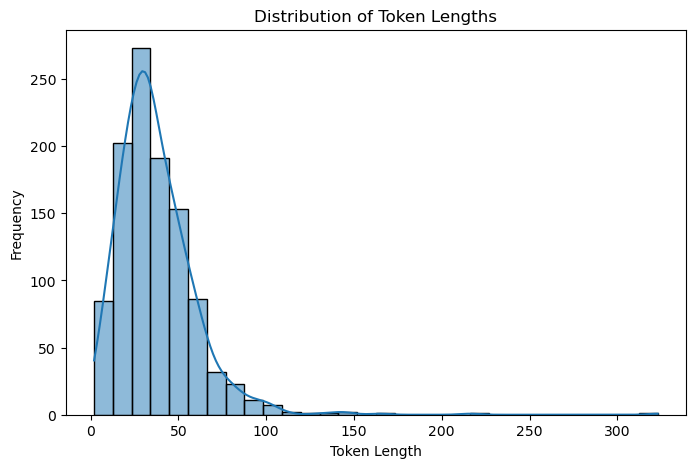

In [5]:
# Distribution of token lengths
token_lengths = df_train['tokens'].apply(len)
plt.figure(figsize=(8, 5))
sns.histplot(token_lengths, bins=30, kde=True)
plt.title('Distribution of Token Lengths')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.show()

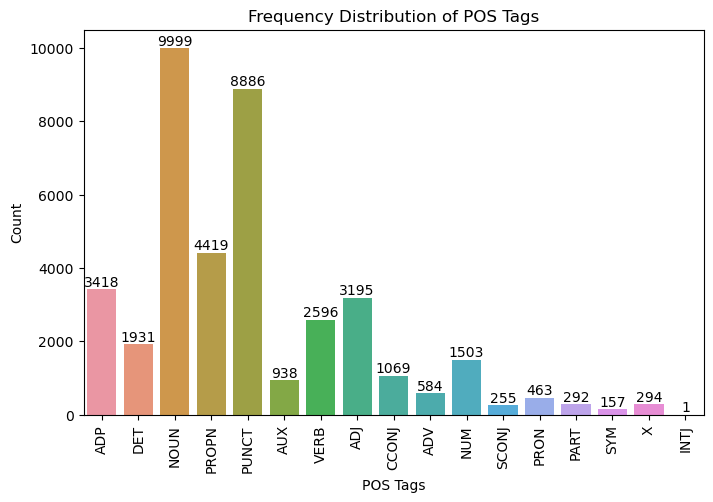

In [34]:
# Frequency distribution of POS tags
pos_tags = [tag for sublist in df_train['pos_tags'] for tag in sublist]
pos_tag_counts = Counter(pos_tags)
plt.figure(figsize=(8, 5))
sns.barplot(x=list(pos_tag_counts.keys()), y=list(pos_tag_counts.values()))
plt.title('Frequency Distribution of POS Tags')
plt.xlabel('POS Tags')
plt.ylabel('Count')
plt.xticks(rotation=90)

# Add data labels
for i, count in enumerate(pos_tag_counts.values()):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

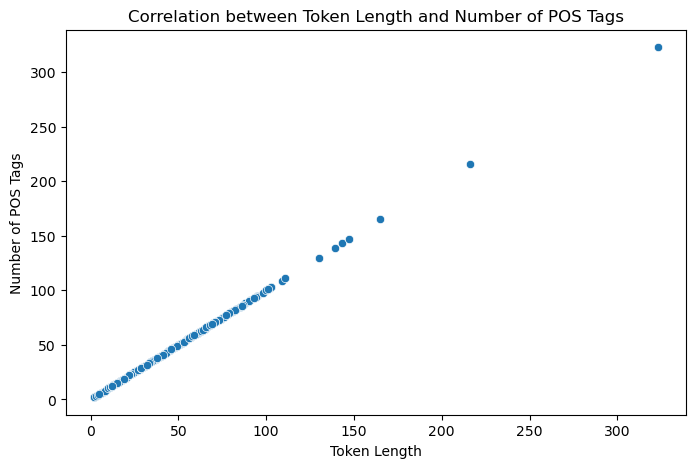

In [31]:
# Correlation between token lengths and number of POS tags
df_train['token_length'] = token_lengths
df_train['num_pos_tags'] = df_train['pos_tags'].apply(len)
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_train, x='token_length', y='num_pos_tags')
plt.title('Correlation between Token Length and Number of POS Tags')
plt.xlabel('Token Length')
plt.ylabel('Number of POS Tags')
plt.show()

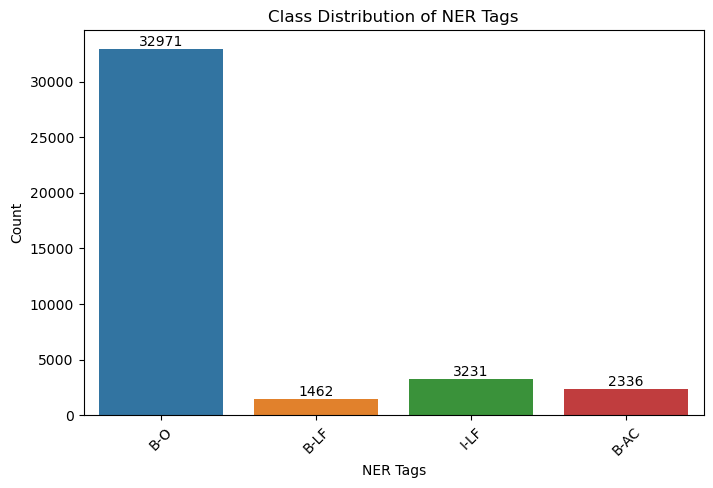

In [30]:
# Class distribution of NER tags
ner_tags = [tag for sublist in df_train['ner_tags'] for tag in sublist]
ner_tag_counts = Counter(ner_tags)
plt.figure(figsize=(8, 5))
sns.barplot(x=list(ner_tag_counts.keys()), y=list(ner_tag_counts.values()))
plt.title('Class Distribution of NER Tags')
plt.xlabel('NER Tags')
plt.ylabel('Count')
plt.xticks(rotation=45)

for i, count in enumerate(ner_tag_counts.values()):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

### 2. Experiments
####  2.1. Data Pre-processing Techniques

In [12]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
train_texts = dataset["train"]["tokens"]

train_texts_flattened = [token for sublist in train_texts for token in sublist]
train_text_combined = ' '.join(train_texts_flattened)

train_tokens = tokenizer(train_text_combined, padding="max_length", truncation=True)

def bigram_tokenizer(sentences):
    all_bigrams = []
    for sent in sentences:
        bigrams = [" ".join(pair) for pair in nltk.bigrams(sent)]
        all_bigrams.append(bigrams)
    return all_bigrams

train_bigrams = bigram_tokenizer(dataset["train"]["tokens"])

In [16]:
train_bigrams[10]

['DHI was',
 'was significantly',
 'significantly correlated',
 'correlated to',
 'to PCL',
 'PCL scores',
 'scores ,',
 ', suggesting',
 'suggesting that',
 'that Veterans',
 'Veterans with',
 'with more',
 'more severe',
 'severe PTSD',
 'PTSD symptoms',
 'symptoms also',
 'also had',
 'had more',
 'more dizziness',
 'dizziness handicap',
 'handicap as',
 'as illustrated',
 'illustrated in',
 'in Fig',
 'Fig 2',
 '2 (',
 '( r2',
 'r2 =',
 '= 0.28',
 '0.28 ,',
 ', p',
 'p <',
 '< 0.0001',
 '0.0001 )',
 ') .']

In [23]:
all_bigrams_flat = [bigram for sublist in train_bigrams for bigram in sublist]
bigram_counts = Counter(all_bigrams_flat)
top_n_bigrams = bigram_counts.most_common(10)
top_n_bigrams

[(') ,', 336),
 (') .', 239),
 ('] .', 210),
 (', and', 199),
 ('of the', 173),
 ('in the', 155),
 (') and', 133),
 (', the', 73),
 (', we', 63),
 ('to the', 61)]

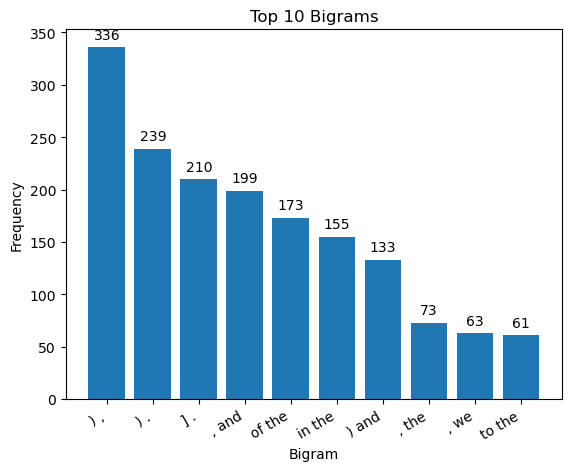

In [30]:
# Plot the frequency distribution
plt.bar(range(len(top_n_bigrams)), [count for _, count in top_n_bigrams], tick_label=[bigram for bigram, _ in top_n_bigrams])
plt.xlabel('Bigram')
plt.ylabel('Frequency')
plt.title('Top 10 Bigrams')
plt.xticks(rotation=30, ha='right')

for i, (_, count) in enumerate(top_n_bigrams):
    plt.text(i, count + 5, str(count), ha='center', va='bottom')

plt.show()

In [101]:
print("Shape of train_vectors:", train_vectors.shape)
print("Shape of train_labels_array:", train_labels_array.shape)

Shape of train_vectors: (1072, 7869)
Shape of train_labels_array: (40000,)


In [102]:
train_labels_array_truncated = train_labels_array[:train_vectors.shape[0]]
print("New shape of train_labels_array after truncation:", train_labels_array_truncated.shape)

New shape of train_labels_array after truncation: (1072,)


#### 2.2. NLP Algorithms/Techniques
##### Algorithm-1: SVM

In [103]:
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(train_vectors, train_labels_array_truncated)

SVC(kernel='linear')

In [104]:
train_predictions = svm_classifier.predict(train_vectors)
f1 = f1_score(train_labels_array_truncated, train_predictions, average='micro')
print("F1-score on the training set:", f1)

F1-score on the training set: 1.0


##### Algorithm-2: RNN

In [129]:
batch_size = 32

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels_array_truncated)
train_labels_tensor = torch.tensor(train_labels_encoded)
train_dataset = TensorDataset(train_data_tensor, train_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [149]:
class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNClassifier, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1])
        return out

#### 2.3. Text Encoding/Transformation

In [162]:
train_tokens = dataset["train"]["tokens"]
train_texts = [' '.join(tokens) for tokens in train_tokens]

# TF-IDF Encoding
vectorizer = TfidfVectorizer(max_features=10000)
train_tfidf = vectorizer.fit_transform(train_texts)

# Train or load a Word2Vec model
word2vec_model = Word2Vec(sentences=train_tokens, vector_size=100, window=5, min_count=1, workers=4)

def sentence_to_vec(sent):
    vecs = []
    for word in sent:
        if word in word2vec_model.wv:
            vecs.append(word2vec_model.wv[word])
    if len(vecs) > 0:
        return np.mean(vecs, axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)

# Encode each sentence using Word2Vec
train_w2v = np.array([sentence_to_vec(sent) for sent in train_tokens])

print("TF-IDF Encoded Data Shape:", train_tfidf.shape)
print("Word2Vec Encoded Data Shape:", train_w2v.shape)

TF-IDF Encoded Data Shape: (1072, 7869)
Word2Vec Encoded Data Shape: (1072, 100)


#### 2.4 Experiment with Additional Dataset

In [6]:
additional_dataset = load_dataset("surrey-nlp/PLOD-filtered")

In [7]:
additional_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'ner_tags'],
        num_rows: 112652
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'ner_tags'],
        num_rows: 24140
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'ner_tags'],
        num_rows: 24140
    })
})

In [32]:
# Load original dataset
original_train_texts = dataset["train"]["tokens"]
original_train_labels = dataset["train"]["ner_tags"]

# Load additional dataset
additional_train_texts = additional_dataset["train"]["tokens"]
additional_train_labels = additional_dataset["train"]["ner_tags"]

# Combine datasets
combined_train_texts = original_train_texts + additional_train_texts
combined_train_labels = original_train_labels + additional_train_labels

In [39]:
combined_train_texts[10]

['DHI',
 'was',
 'significantly',
 'correlated',
 'to',
 'PCL',
 'scores',
 ',',
 'suggesting',
 'that',
 'Veterans',
 'with',
 'more',
 'severe',
 'PTSD',
 'symptoms',
 'also',
 'had',
 'more',
 'dizziness',
 'handicap',
 'as',
 'illustrated',
 'in',
 'Fig',
 '2',
 '(',
 'r2',
 '=',
 '0.28',
 ',',
 'p',
 '<',
 '0.0001',
 ')',
 '.']

In [40]:
combined_train_labels[10]

['B-AC',
 'B-O',
 'B-O',
 'B-O',
 'B-O',
 'B-AC',
 'B-O',
 'B-O',
 'B-O',
 'B-O',
 'B-O',
 'B-O',
 'B-O',
 'B-O',
 'B-AC',
 'B-O',
 'B-O',
 'B-O',
 'B-O',
 'B-O',
 'B-O',
 'B-O',
 'B-O',
 'B-O',
 'B-O',
 'B-O',
 'B-O',
 'B-O',
 'B-O',
 'B-O',
 'B-O',
 'B-O',
 'B-O',
 'B-O',
 'B-O',
 'B-O']

In [ ]:
train_encodings = []

# Tokenize each text individually
for data in combined_train_data:
    # Tokenize the text and add special tokens
    encoding = tokenizer(data[0], truncation=True, padding='max_length', max_length=max_length)
    train_encodings.append(encoding)

# Convert labels to tensors
train_labels_tensor = torch.tensor(combined_train_labels)

In [4]:
proportions = [0.5, 0.7, 0.9]

In [46]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Initialize SVM classifier
svm_classifier = SVC(kernel='linear')

for proportion in proportions:
    # Split the combined dataset into train and validation sets
    train_texts_split, _, train_labels_split, _ = train_test_split(combined_train_texts, combined_train_labels, train_size=proportion, random_state=42)

    # Tokenize the texts
    train_encodings = tokenizer(train_texts_split, truncation=True, padding=True)

    # Convert labels to tensors
    train_labels_tensor = torch.tensor(train_labels_split)

    # Train SVM classifier
    svm_classifier.fit(train_encodings, train_labels_tensor)

    # Evaluate SVM classifier on fixed validation set
    val_encodings = tokenizer(val_texts, truncation=True, padding=True)
    val_labels_tensor = torch.tensor(val_labels)
    
    svm_preds = svm_classifier.predict(val_encodings)
    svm_accuracy = accuracy_score(val_labels, svm_preds)

    print(f"Proportion: {proportion}, SVM Accuracy: {svm_accuracy}")

TypeError: TextEncodeInput must be Union[TextInputSequence, Tuple[InputSequence, InputSequence]]

### 3. Experimental Results and Analysis

In [36]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
max_length = 128

def tokenize_and_encode(texts, max_length):
    return tokenizer(texts, padding="max_length", truncation=True, max_length=max_length, return_tensors='np')


def preprocess_data(examples):
    texts = [" ".join(tokens) for tokens in examples['tokens']]
    tokenized_inputs = tokenize_and_encode(texts, max_length)
    labels = []
    for label_list in examples['ner_tags']:
        padded_labels = label_list + [-100] * (max_length - len(label_list))
        labels.append(padded_labels[:max_length])

    return tokenized_inputs, np.array(labels)

train_dataset = dataset['train']
test_dataset = dataset['test']

train_encodings, train_labels = preprocess_data(train_dataset)
test_encodings, test_labels = preprocess_data(test_dataset)

train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    train_encodings['input_ids'], train_labels, test_size=0.1, random_state=42
)

In [37]:
print(f"Train inputs shape: {train_inputs.shape}")
print(f"Validation inputs shape: {val_inputs.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Validation labels shape: {val_labels.shape}")

Train inputs shape: (964, 128)
Validation inputs shape: (108, 128)
Train labels shape: (964, 128)
Validation labels shape: (108, 128)


In [42]:
label_map = {
    'O': 0, 'B-AC': 1, 'I-AC': 2, 'B-LF': 3, 'I-LF': 4, 'B-O': 5
}

def convert_labels_to_int(labels, label_map):
    converted_labels = []
    for label_list in labels:
        converted_label_list = []
        for label in label_list:
            if label == '-100':
                converted_label_list.append(-100)
            elif label in label_map:
                converted_label_list.append(label_map[label])
            else:
                raise ValueError(f"Label {label} not found in label_map and is not a padding value.")
        converted_labels.append(converted_label_list)
    return converted_labels

In [43]:
def create_dataloader(input_ids, attention_masks, labels, label_map, batch_size=32):
    print(f"Input IDs shape: {input_ids.shape}")
    print(f"Attention Masks shape: {attention_masks.shape}")

    if isinstance(labels, list):
        print(f"Labels shape: {len(labels)}, {len(labels[0]) if labels else 'N/A'}")
    elif isinstance(labels, np.ndarray):
        print(f"Labels shape: {labels.shape}")

    labels = convert_labels_to_int(labels, label_map)

    if input_ids.shape[0] != attention_masks.shape[0]:
        print("Adjusting mismatch in attention masks...")
        attention_masks = attention_masks[:input_ids.shape[0]]

    assert input_ids.shape[0] == attention_masks.shape[0] == len(labels), "Mismatch in the number of examples among tensors"

    input_ids = torch.tensor(input_ids, dtype=torch.long)
    attention_masks = torch.tensor(attention_masks, dtype=torch.long)
    labels = torch.tensor(labels, dtype=torch.long)

    data = TensorDataset(input_ids, attention_masks, labels)
    
    sampler = RandomSampler(data)
    dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size)
    return dataloader

In [44]:
batch_size = 16
label_map = {'O': 0, 'B-AC': 1, 'I-AC': 2, 'B-LF': 3, 'I-LF': 4, 'B-O': 5}
train_dataloader = create_dataloader(train_inputs, train_encodings['attention_mask'], train_labels, label_map, batch_size)

Input IDs shape: (964, 128)
Attention Masks shape: (1072, 128)
Labels shape: (964, 128)
Adjusting mismatch in attention masks...


In [45]:
validation_dataloader = create_dataloader(val_inputs, test_encodings['attention_mask'], val_labels, label_map, batch_size)

Input IDs shape: (108, 128)
Attention Masks shape: (153, 128)
Labels shape: (108, 128)
Adjusting mismatch in attention masks...


##### 3.1 BERT-Based Model with Fine-Tuning

In [46]:
label_map = {'O': 0, 'B-AC': 1, 'I-AC': 2, 'B-LF': 3, 'I-LF': 4, 'B-O': 5}
num_labels = len(label_map)

model = BertForTokenClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=num_labels,
    output_attentions=False,
    output_hidden_states=False
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: 

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [47]:
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

C:\Users\User\AppData\Roaming\Python\Python39\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
epochs = 10

for epoch in range(epochs):
    print(f'\nEpoch {epoch + 1}/{epochs}')
    model.train()
    total_loss = 0

    for step, batch in enumerate(tqdm(train_dataloader)):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        model.zero_grad()

        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0] 
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f'Average train loss: {avg_train_loss}')

    # Validation loop
    model.eval()
    predictions, true_labels = [], []

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_input_mask)

        logits = outputs[0].detach().cpu().numpy() 
        label_ids = b_labels.to('cpu').numpy()
        
        batch_predictions = [p for sublist in np.argmax(logits, axis=2) for p in sublist]
        batch_true_labels = [label for sublist in label_ids for label in sublist]
        predictions.extend(batch_predictions)
        true_labels.extend(batch_true_labels)

    mask = np.array(true_labels) != -100
    filtered_labels = np.array(true_labels)[mask]
    filtered_predictions = np.array(predictions)[mask]
    print("Validation F1 Score:", f1_score(filtered_labels, filtered_predictions, average='macro'))


Epoch 1/10


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [10:35<00:00, 10.42s/it]


Average train loss: 0.7012384147917639
Validation F1 Score: 0.22537586061542783

Epoch 2/10


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [10:45<00:00, 10.59s/it]


Average train loss: 0.5931670460544649
Validation F1 Score: 0.2577453340613129

Epoch 3/10


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [10:40<00:00, 10.51s/it]


Average train loss: 0.5398485157333437
Validation F1 Score: 0.288632606015268

Epoch 4/10


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [10:42<00:00, 10.53s/it]


Average train loss: 0.49718391846437926
Validation F1 Score: 0.32760511517583535

Epoch 5/10


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [10:26<00:00, 10.27s/it]


Average train loss: 0.4512880967288721
Validation F1 Score: 0.41058760047337195

Epoch 6/10


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [10:33<00:00, 10.39s/it]


Average train loss: 0.41566518608663905
Validation F1 Score: 0.4182237535599409

Epoch 7/10


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [10:45<00:00, 10.57s/it]


Average train loss: 0.39130269552840563
Validation F1 Score: 0.43465802298414125

Epoch 8/10


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [10:50<00:00, 10.66s/it]


Average train loss: 0.36474435617689227
Validation F1 Score: 0.44350557438563

Epoch 9/10


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [10:41<00:00, 10.52s/it]


Average train loss: 0.3442351185396069
Validation F1 Score: 0.45005292543138875

Epoch 10/10


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [10:54<00:00, 10.72s/it]


Average train loss: 0.3242394797137526
Validation F1 Score: 0.4491950622896691


In [73]:
def plot_confusion_matrix(conf_matrix, labels=None):
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(filtered_labels))
    disp.plot(cmap=plt.cm.Blues)
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    plt.show()

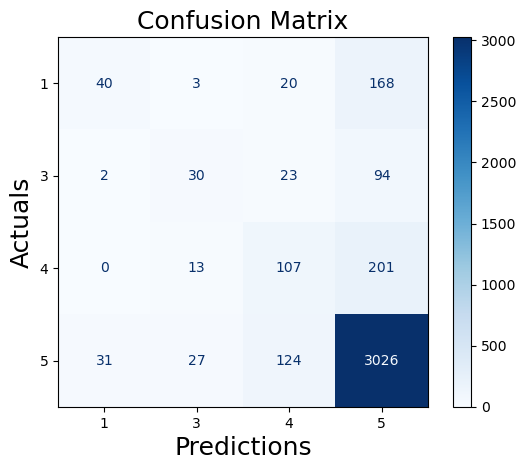

In [74]:
conf_matrix = confusion_matrix(filtered_labels, filtered_predictions)
plot_confusion_matrix(conf_matrix)


Epoch 1/10


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [10:33<00:00, 10.38s/it]


Average train loss: 0.3001781545701574

Epoch 2/10


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [10:25<00:00, 10.25s/it]


Average train loss: 0.29138364606216305

Epoch 3/10


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [10:27<00:00, 10.28s/it]


Average train loss: 0.2715560029276082

Epoch 4/10


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [10:29<00:00, 10.32s/it]


Average train loss: 0.2536182308294734

Epoch 5/10


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [11:09<00:00, 10.98s/it]


Average train loss: 0.24086672311923543

Epoch 6/10


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [10:54<00:00, 10.73s/it]


Average train loss: 0.22384072376079248

Epoch 7/10


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [10:52<00:00, 10.69s/it]


Average train loss: 0.20684228580994685

Epoch 8/10


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [10:42<00:00, 10.54s/it]


Average train loss: 0.19518712016402698

Epoch 9/10


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [10:39<00:00, 10.48s/it]


Average train loss: 0.18759087491475168

Epoch 10/10


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [10:24<00:00, 10.23s/it]


Average train loss: 0.1696108051987945


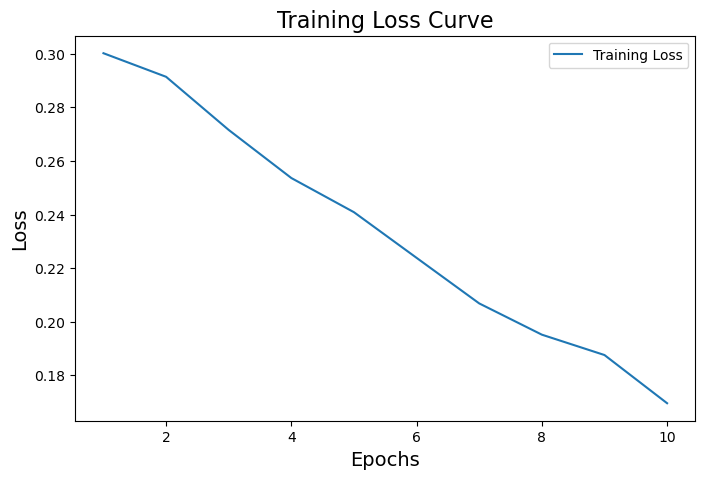

In [56]:
train_losses = []

for epoch in range(epochs):
    print(f'\nEpoch {epoch + 1}/{epochs}')
    model.train()
    total_loss = 0

    for step, batch in enumerate(tqdm(train_dataloader)):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        model.zero_grad()

        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]  # Loss is always the first item when labels are provided
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f'Average train loss: {avg_train_loss}')
    train_losses.append(avg_train_loss)

# Plotting the training loss
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training Loss Curve', fontsize=16)
plt.legend()
plt.show()

#### 3.2 BERT-Based Model with Tokeniser

In [58]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=6)

# Prepare the data
def encode_examples(examples, max_length=128):
    texts = [" ".join(example['tokens']) for example in examples]
    tokens = tokenizer.batch_encode_plus(
        texts,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    # Prepare and convert labels using the mapping
    padded_labels = []
    for example in examples:
        label_ids = [label_map[label] for label in example['ner_tags']]

        label_ids = label_ids[:max_length]
        label_ids += [label_map['O']] * (max_length - len(label_ids))
        padded_labels.append(label_ids)

    labels_tensor = torch.tensor(padded_labels, dtype=torch.long)
    return tokens, labels_tensor

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: 

In [59]:
# Now call encode_examples with the dataset
train_tokens, train_labels = encode_examples(dataset['train'])
val_tokens, val_labels = encode_examples(dataset['validation'])

train_tokens, train_labels = encode_examples(dataset['train'])
val_tokens, val_labels = encode_examples(dataset['validation'])

In [60]:
# Dataloaders
train_data = TensorDataset(train_tokens['input_ids'], train_tokens['attention_mask'], train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=16)

val_data = TensorDataset(val_tokens['input_ids'], val_tokens['attention_mask'], val_labels)
val_dataloader = DataLoader(val_data, batch_size=16)

In [61]:
optimizer = AdamW(model.parameters(), lr=2e-5)

def train_model(model, dataloader, optimizer):
    model.train()
    total_loss = 0
    for batch in dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        model.zero_grad()
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)


def evaluate_model(model, dataloader):
    model.eval()
    predictions, true_labels = [], []
    for batch in dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = outputs.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)
    predictions = [p_i for sublist in predictions for p_i in sublist if p_i != -100]
    true_labels = [l_i for sublist in true_labels for l_i in sublist if l_i != -100]

    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted', zero_division=1)
    return f1

# Run training and evaluation
for _ in range(3):
    train_model(model, train_dataloader, optimizer)

f1_score = evaluate_model(model, val_dataloader)
print("F1 Score:", f1_score)

C:\Users\User\AppData\Roaming\Python\Python39\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


F1 Score: 0.9229818446366765


In [66]:
def train_model(model, dataloader, optimizer):
    model.train()
    total_loss = 0
    losses = []
    for batch in dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        model.zero_grad()
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        losses.append(loss.item())
    average_loss = total_loss / len(dataloader)
    return losses

In [67]:
def evaluate_model(model, dataloader):
    model.eval()
    predictions, true_labels = [], []
    for batch in dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = outputs.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        batch_preds = np.argmax(logits, axis=2)
        for i in range(batch_preds.shape[0]):
            pred = [p for j, p in enumerate(batch_preds[i]) if b_labels[i, j] != -100]
            label = [l for j, l in enumerate(label_ids[i]) if l != -100]
            predictions.extend(pred)
            true_labels.extend(label)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted', zero_division=1)
    conf_matrix = confusion_matrix(true_labels, predictions)
    return f1, conf_matrix

In [76]:
def plot_loss_curve(losses):
    plt.figure(figsize=(8, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Iterations', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.title('Training Loss Curve', fontsize=16)
    plt.legend()
    plt.show()

In [69]:
all_losses = []
for _ in range(3):
    epoch_losses = train_model(model, train_dataloader, optimizer)
    all_losses.extend(epoch_losses)

f1_score, conf_matrix = evaluate_model(model, val_dataloader)
print("F1 Score:", f1_score)

F1 Score: 0.9344740687624352


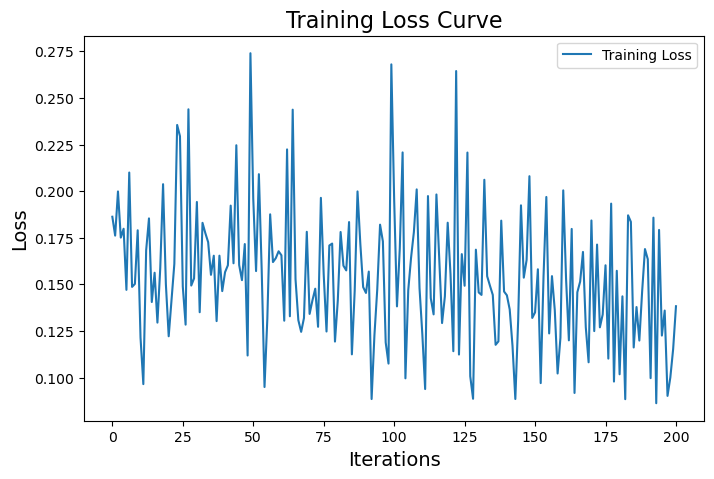

In [77]:
plot_loss_curve(all_losses)

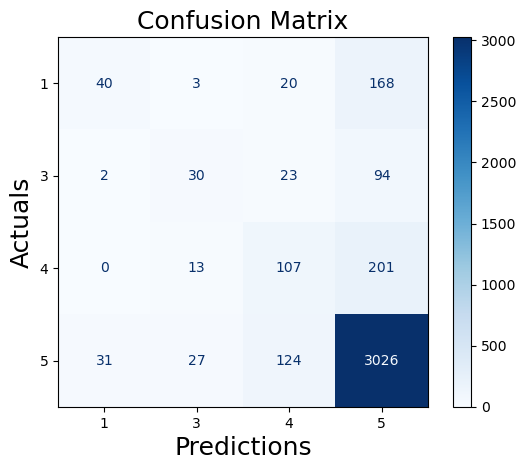

In [75]:
plot_confusion_matrix(conf_matrix, np.unique(filtered_labels))

#### 3.3 RNN-Based Model

In [85]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [87]:
def encode_examples(examples, max_length=128):
    texts = [" ".join(example['tokens']) for example in examples]
    tokens = tokenizer.batch_encode_plus(
        texts, max_length=max_length, padding='max_length', truncation=True, return_tensors='pt'
    )

    padded_labels = []
    for example in examples:
        label_ids = [label_map[label] for label in example['ner_tags']]
        label_ids = label_ids[:max_length] + [label_map['O']] * (max_length - len(label_ids))
        padded_labels.append(label_ids)

    labels_tensor = torch.tensor(padded_labels, dtype=torch.long)
    return tokens, labels_tensor

train_tokens, train_labels = encode_examples(dataset['train'])

In [88]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x.long())
        output, _ = self.rnn(embedded)
        output = self.fc(output)
        return output

In [89]:
def train_model(model, data_loader, optimizer, criterion, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for inputs, labels in data_loader:
            inputs = inputs.float() 
            labels = labels.view(-1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.view(-1, outputs.shape[-1]), labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch + 1}, Loss: {total_loss / len(data_loader)}')

In [90]:
def evaluate_model(model, data_loader):
    model.eval()
    true_labels, predictions = [], []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.float()
            labels = labels.view(-1)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, -1)
            predicted = predicted.view(-1).numpy()

            valid_indices = labels != -100
            valid_labels = labels[valid_indices].numpy()
            valid_predictions = predicted[valid_indices]

            true_labels.extend(valid_labels)
            predictions.extend(valid_predictions)
    return f1_score(true_labels, predictions, average='macro')

In [92]:
vocab_size = tokenizer.vocab_size
embedding_dim = 768  # Typical embedding size used in many models like BERT
input_dim = 768  # Typically the size of the embedding layer
hidden_dim = 256
output_dim = len(label_map)


rnn_model = RNNModel(vocab_size, embedding_dim, hidden_dim, output_dim)
optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# DataLoader remains unchanged
train_data = TensorDataset(train_tokens['input_ids'], train_labels)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

train_model(rnn_model, train_loader, optimizer, criterion)
f1 = evaluate_model(rnn_model, train_loader)
print(f'RNN Model F1 Score: {f1}')

Epoch 1, Loss: 0.5009846774970784
Epoch 2, Loss: 0.33329424568835425
Epoch 3, Loss: 0.29586301218060884
Epoch 4, Loss: 0.2668624625486486
Epoch 5, Loss: 0.23725676711867838
Epoch 6, Loss: 0.21981622541652007
Epoch 7, Loss: 0.20299372252296
Epoch 8, Loss: 0.18468514128642924
Epoch 9, Loss: 0.16951779188478694
Epoch 10, Loss: 0.14977172871722894
RNN Model F1 Score: 0.5453548791357934


In [93]:
def train_model(model, data_loader, optimizer, criterion, epochs=10):
    model.train()
    epoch_losses = [] 
    for epoch in range(epochs):
        total_loss = 0
        for inputs, labels in data_loader:
            inputs = inputs.float() 
            labels = labels.view(-1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.view(-1, outputs.shape[-1]), labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        epoch_loss = total_loss / len(data_loader)
        epoch_losses.append(epoch_loss)
        print(f'Epoch {epoch + 1}, Loss: {epoch_loss}')
    return epoch_losses

In [94]:
def evaluate_model(model, data_loader):
    model.eval()
    true_labels, predictions = [], []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.float()
            labels = labels.view(-1)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, -1)
            predicted = predicted.view(-1).numpy()

            valid_indices = labels != -100
            valid_labels = labels[valid_indices].numpy()
            valid_predictions = predicted[valid_indices]

            true_labels.extend(valid_labels)
            predictions.extend(valid_predictions)
    f1 = f1_score(true_labels, predictions, average='macro')
    conf_mat = confusion_matrix(true_labels, predictions)
    return f1, conf_mat

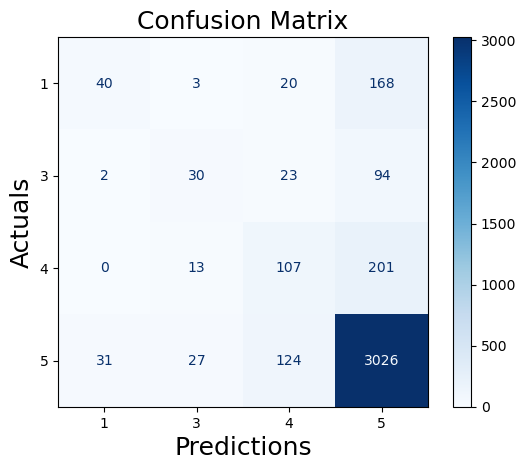

In [96]:
plot_confusion_matrix(conf_matrix, list(label_map.keys()))

Epoch 1, Loss: 0.1315923120607348
Epoch 2, Loss: 0.11988355964422226
Epoch 3, Loss: 0.10737920727799921
Epoch 4, Loss: 0.09964600249248393
Epoch 5, Loss: 0.08946756865171825
Epoch 6, Loss: 0.07873274133924175
Epoch 7, Loss: 0.06978633945040844
Epoch 8, Loss: 0.062108046210864014
Epoch 9, Loss: 0.05570897920166745
Epoch 10, Loss: 0.05056081832770039
RNN Model F1 Score: 0.9049302996097192


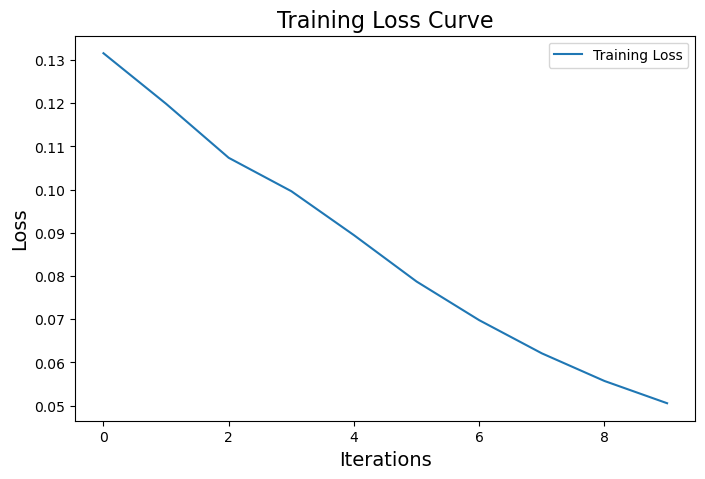

In [97]:
losses = train_model(rnn_model, train_loader, optimizer, criterion)
f1, conf_matrix = evaluate_model(rnn_model, train_loader)
print(f'RNN Model F1 Score: {f1}')
plot_loss_curve(losses)

#### 3.4 Hyperparameter Tuning for RNN-Based Model

In [99]:
def evaluate_model(model, data_loader):
    model.eval()
    true_labels, predictions = [], []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.float()
            labels = labels.view(-1)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, -1)
            valid_indices = labels != -100
            valid_labels = labels[valid_indices].numpy()
            valid_predictions = predicted.view(-1).numpy()[valid_indices]
            true_labels.extend(valid_labels)
            predictions.extend(valid_predictions)
    return f1_score(true_labels, predictions, average='macro')

# Define the hyperparameters to test
learning_rates = [1e-5, 2e-5, 5e-5]
epochs_list = [3, 5, 10]

# Initialize the model parameters
vocab_size = tokenizer.vocab_size
embedding_dim = 768
hidden_dim = 256
output_dim = len(label_map)

results = {}

for lr in learning_rates:
    for epochs in epochs_list:
        model = RNNModel(vocab_size, embedding_dim, hidden_dim, output_dim)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            model.train()
            for inputs, labels in train_loader:
                inputs = inputs.float()
                labels = labels.view(-1)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs.view(-1, outputs.shape[-1]), labels)
                loss.backward()
                optimizer.step()

        f1 = evaluate_model(model, train_loader)
        results[(lr, epochs)] = f1
        print(f'Learning Rate: {lr}, Epochs: {epochs}, F1 Score: {f1}')

Learning Rate: 1e-05, Epochs: 3, F1 Score: 0.26002293085692724
Learning Rate: 1e-05, Epochs: 5, F1 Score: 0.2718727743831028
Learning Rate: 1e-05, Epochs: 10, F1 Score: 0.2910983436258328
Learning Rate: 2e-05, Epochs: 3, F1 Score: 0.2850156531536126
Learning Rate: 2e-05, Epochs: 5, F1 Score: 0.28694583539324564
Learning Rate: 2e-05, Epochs: 10, F1 Score: 0.2855011366288089
Learning Rate: 5e-05, Epochs: 3, F1 Score: 0.2864881770271244
Learning Rate: 5e-05, Epochs: 5, F1 Score: 0.2873344068749118
Learning Rate: 5e-05, Epochs: 10, F1 Score: 0.3418820853733272


In [100]:
best_params = max(results, key=results.get)
best_f1 = results[best_params]

print(f'Best Parameters: Learning Rate = {best_params[0]}, Epochs = {best_params[1]}')
print(f'Best F1 Score: {best_f1}')

Best Parameters: Learning Rate = 5e-05, Epochs = 10
Best F1 Score: 0.3418820853733272


In [101]:
def train_model(model, data_loader, optimizer, criterion, epochs):
    model.train()
    losses = []
    for epoch in range(epochs):
        total_loss = 0
        for inputs, labels in data_loader:
            inputs = inputs.float()
            labels = labels.view(-1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.view(-1, outputs.shape[-1]), labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        average_loss = total_loss / len(data_loader)
        losses.append(average_loss)
    return losses

In [102]:
def evaluate_model(model, data_loader):
    model.eval()
    true_labels, predictions = [], []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.float()
            labels = labels.view(-1)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, -1)
            valid_indices = labels != -100
            valid_labels = labels[valid_indices].numpy()
            valid_predictions = predicted.view(-1).numpy()[valid_indices]
            true_labels.extend(valid_labels)
            predictions.extend(valid_predictions)
    f1 = f1_score(true_labels, predictions, average='macro')
    conf_mat = confusion_matrix(true_labels, predictions)
    return f1, conf_mat, true_labels, predictions

In [104]:
results = {}
all_losses = {}

for lr in learning_rates:
    for epochs in epochs_list:
        model = RNNModel(vocab_size, embedding_dim, hidden_dim, output_dim)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        losses = train_model(model, train_loader, optimizer, criterion, epochs)
        f1, conf_mat, _, _ = evaluate_model(model, train_loader)
        results[(lr, epochs)] = f1
        all_losses[(lr, epochs)] = losses
        print(f'Learning Rate: {lr}, Epochs: {epochs}, F1 Score: {f1}')

best_params = max(results, key=results.get)
best_f1 = results[best_params]
best_losses = all_losses[best_params]

print(f'Best Parameters: Learning Rate = {best_params[0]}, Epochs = {best_params[1]}')
print(f'Best F1 Score: {best_f1}')
best_f1, best_conf_mat, _, _ = evaluate_model(model, train_loader)

Learning Rate: 1e-05, Epochs: 3, F1 Score: 0.25970379793085724
Learning Rate: 1e-05, Epochs: 5, F1 Score: 0.27938582874764856
Learning Rate: 1e-05, Epochs: 10, F1 Score: 0.2869670428066378
Learning Rate: 2e-05, Epochs: 3, F1 Score: 0.28026753952847866
Learning Rate: 2e-05, Epochs: 5, F1 Score: 0.2903658543019953
Learning Rate: 2e-05, Epochs: 10, F1 Score: 0.2887913679050296
Learning Rate: 5e-05, Epochs: 3, F1 Score: 0.2906631592447578
Learning Rate: 5e-05, Epochs: 5, F1 Score: 0.2848609614805371
Learning Rate: 5e-05, Epochs: 10, F1 Score: 0.34224790101388974
Best Parameters: Learning Rate = 5e-05, Epochs = 10
Best F1 Score: 0.34224790101388974


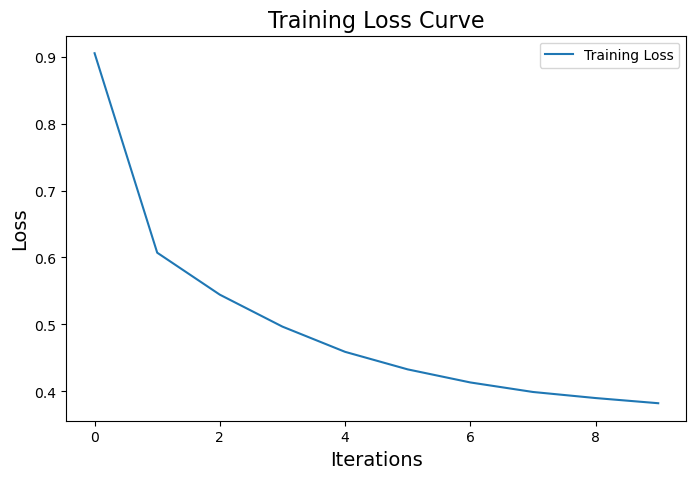

In [105]:
plot_loss_curve(best_losses)

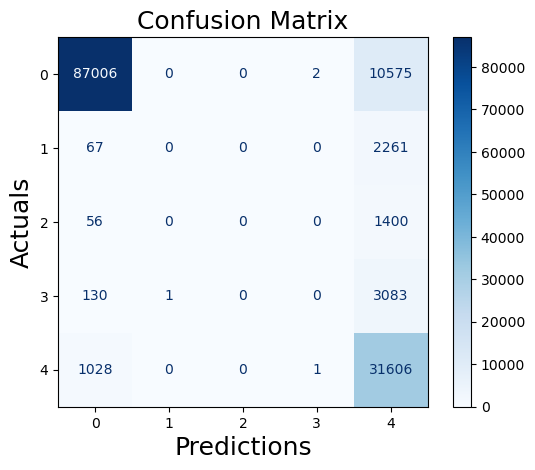

In [115]:
plot_confusion_matrix(best_conf_mat)